In [1]:
from pyspark.sql import SparkSession
import time

spark = SparkSession.builder \
    .appName("CV compare") \
    .master("local[2]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.network.timeout", "12000s") \
    .config("spark.executor.heartbeatInterval", "2000s") \
    .getOrCreate()


## HDFS

### RDD

In [11]:
start_time_hdfs_rdd = time.time()
citizens_rdd_hdfs = spark.sparkContext.textFile("hdfs://172.30.2.147:9000/demo_directory/citizens_data.csv")
header = citizens_rdd_hdfs.first()
data_citizens_rdd_hdfs = citizens_rdd_hdfs.filter(lambda line: line != header)

cities_in_country = data_citizens_rdd_hdfs \
        .map(lambda x: (x.split(",")[4],1)) \
        .reduceByKey(lambda x,y: x+y)
print(cities_in_country.collect())

end_time_hdfs_rdd = time.time()
time_hdfs_rdd = end_time_hdfs_rdd - start_time_hdfs_rdd
print("Thời gian chạy với HDFS: {:.2f} giây".format(time_hdfs_rdd))

[('Togo', 366794), ('Palestinian Territory', 367703), ('Kyrgyz Republic', 367174), ('Puerto Rico', 366745), ('Mauritania', 366588), ('Austria', 367211), ('Northern Mariana Islands', 368405), ('Peru', 367667), ('Portugal', 366957), ('Turkmenistan', 366817), ('Bahrain', 366968), ('Poland', 367737), ('Kiribati', 367401), ('Brunei Darussalam', 367760), ('United Arab Emirates', 367391), ('Lesotho', 367501), ('Guinea', 368162), ('Ireland', 367214), ('India', 367291), ('Argentina', 367782), ('Haiti', 367853), ('South Georgia and the South Sandwich Islands', 367398), ('Namibia', 367558), ('Samoa', 368769), ('Vanuatu', 367591), ('Micronesia', 366557), ('Myanmar', 366389), ('Mauritius', 367242), ('Kuwait', 367709), ('Angola', 367508), ('British Indian Ocean Territory (Chagos Archipelago)', 367854), ('Mali', 367235), ('Guam', 367291), ('Oman', 367597), ('United States of America', 367527), ('Timor-Leste', 366837), ('Aruba', 368387), ('Tokelau', 367206), ('Croatia', 367822), ('Guadeloupe', 367843)

### DataFrame 

In [9]:
from pyspark.sql.functions import count  # Import hàm count
import time

start_time_hdfs_df = time.time()
citizens_df = spark.read.csv("hdfs://172.30.2.147:9000/demo_directory/citizens_data.csv", 
                           header = "true", inferSchema = "true")
citizens_df\
    .groupBy("country") \
    .agg(
        count("*").alias("the number citizens")
    ).show()
end_time_hdfs_df = time.time()
time_hdfs_df = end_time_hdfs_df - start_time_hdfs_df
print("Thời gian chạy dùng spark dataframe với HDFS: {:.2f} giây".format(time_hdfs_df))

+--------------------+-------------------+
|             country|the number citizens|
+--------------------+-------------------+
|                Chad|             367644|
|            Anguilla|             366526|
|            Paraguay|             367688|
|               Macao|             366974|
|Heard Island and ...|             367622|
|               Yemen|             367245|
|             Senegal|             366689|
|              Sweden|             367410|
|             Tokelau|             367206|
|French Southern T...|             367279|
|            Kiribati|             367401|
|              Guyana|             367416|
|             Eritrea|             366794|
|         Philippines|             366518|
|              Jersey|             366988|
|               Tonga|             367806|
|            Djibouti|             367388|
|      Norfolk Island|             368263|
|            Malaysia|             368297|
|           Singapore|             366416|
+----------

### SQL

In [17]:
start_time_hdfs_sql = time.time()
citizens_df_hdfs = spark.read.csv("hdfs://172.30.2.147:9000/demo_directory/citizens_data.csv", 
                                  header="true", inferSchema="true")

# Đăng ký DataFrame là một bảng tạm thời trong Spark SQL
citizens_df_hdfs.createOrReplaceTempView("citizens_hdfs")

# Thực thi câu lệnh SQL
result_hdfs = spark.sql("""
    SELECT country, COUNT(*) AS `the number citizens`
    FROM citizens_hdfs
    GROUP BY country
""")
result_hdfs.show(5)

end_time_hdfs_sql = time.time()
time_hdfs_sql = end_time_hdfs_sql - start_time_hdfs_sql

print(f"Thời gian chạy dùng Spark SQL với HDFS: {time_hdfs_sql:.2f} giây")

+--------------------+-------------------+
|             country|the number citizens|
+--------------------+-------------------+
|                Chad|             367644|
|            Anguilla|             366526|
|            Paraguay|             367688|
|               Macao|             366974|
|Heard Island and ...|             367622|
+--------------------+-------------------+
only showing top 5 rows

Thời gian chạy dùng Spark SQL với HDFS: 1792.85 giây


### Pandas

In [21]:
pip install pyarrow


   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   -- ------------------------------------- 1.6/25.1 MB 14.1 MB/s eta 0:00:02
   ---------- ----------------------------- 6.8/25.1 MB 20.0 MB/s eta 0:00:01
   -------------------- ------------------- 12.6/25.1 MB 22.6 MB/s eta 0:00:01
   ----------------------------- ---------- 18.6/25.1 MB 24.5 MB/s eta 0:00:01
   -------------------------------------- - 24.4/25.1 MB 25.3 MB/s eta 0:00:01
   ---------------------------------------  24.9/25.1 MB 24.6 MB/s eta 0:00:01
   ---------------------------------------  24.9/25.1 MB 24.6 MB/s eta 0:00:01
   ---------------------------------------- 25.1/25.1 MB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import time
import pandas as pd

# Đọc dữ liệu từ file CSV trên HDFS và tính thời gian
start_time_hdfs_pandas = time.time()

# Đọc dữ liệu từ file CSV trên HDFS (đảm bảo đường dẫn đúng)
file_path = r"D:\Data Engineer\dwh and etl\lesson\lesson 2\documents\Talend\Sync Hadoop to DWH\citizens_data.csv"
citizens_df_hdfs_pandas = pd.read_csv(file_path)

# Tìm cột chứa từ khóa 'city' trong tên cột
columns_with_city = citizens_df_hdfs_pandas.columns[citizens_df_hdfs_pandas.columns.str.contains('city', case=False)].tolist()
print(f"Các cột có chứa từ 'city': {columns_with_city}")

# Đếm số lượng thành phố trong cột liên quan đến 'city'
if columns_with_city:
    city_column = columns_with_city[0]  # Lấy cột đầu tiên khớp với 'city'
    cities_in_country_hdfs_pandas = citizens_df_hdfs_pandas.groupby(city_column)[city_column].count()
    print(cities_in_country_hdfs_pandas)
else:
    print("Không tìm thấy cột nào chứa từ 'city'.")

# Tính thời gian kết thúc
end_time_hdfs_pandas = time.time()
time_hdfs_pandas = end_time_hdfs_pandas - start_time_hdfs_pandas
print(f"Thời gian xử lý bằng pandas với HDFS: {time_hdfs_pandas:.2f} giây")


MemoryError: Unable to allocate 1.00 MiB for an array with shape (131072,) and data type int64

--> không thể dùng pandas để đọch được file trên hdfs

### Visual

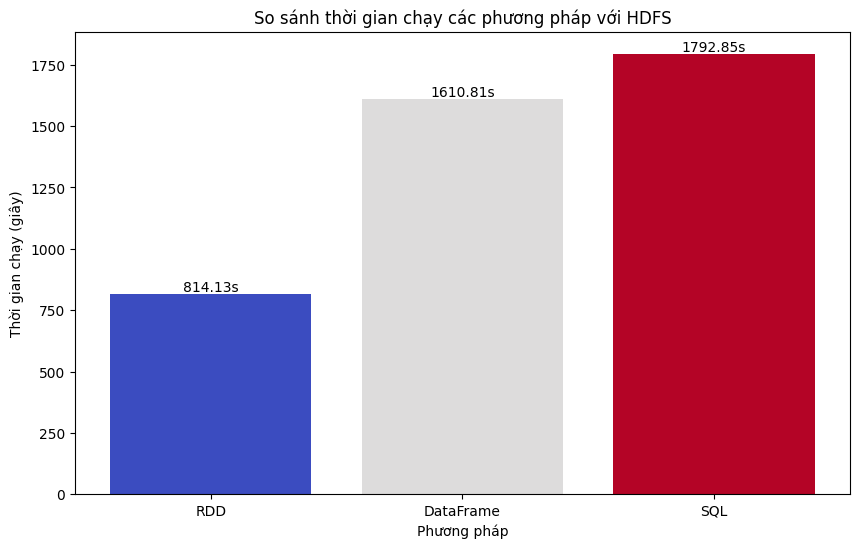

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Các thời gian thực hiện của từng phương pháp
times = [time_hdfs_rdd, time_hdfs_df, time_hdfs_sql]
labels = ["RDD", "DataFrame", "SQL"]

# Màu sắc dựa trên thời gian: thời gian ngắn hơn có màu xanh, dài hơn có màu đỏ
colors = plt.cm.coolwarm(np.linspace(0, 1, len(times)))

# Vẽ biểu đồ bar
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color=colors)

# Thêm giá trị thời gian chạy vào mỗi thanh bar
for bar, time in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{time:.2f}s', 
             ha='center', va='bottom')

# Thiết lập tiêu đề và nhãn
plt.title("So sánh thời gian chạy các phương pháp với HDFS")
plt.xlabel("Phương pháp")
plt.ylabel("Thời gian chạy (giây)")

# Hiển thị biểu đồ
plt.show()